<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Feature-Selection" data-toc-modified-id="Feature-Selection-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Feature Selection</a></span><ul class="toc-item"><li><span><a href="#Looking-at-features-that-are-highly-correlated" data-toc-modified-id="Looking-at-features-that-are-highly-correlated-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Looking at features that are highly correlated</a></span><ul class="toc-item"><li><span><a href="#Looking-at-the-identical-features" data-toc-modified-id="Looking-at-the-identical-features-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Looking at the identical features</a></span></li><li><span><a href="#Looking-at-non-identical-correlated-features" data-toc-modified-id="Looking-at-non-identical-correlated-features-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Looking at non-identical correlated features</a></span><ul class="toc-item"><li><span><a href="#Cliques-of-features" data-toc-modified-id="Cliques-of-features-1.1.2.1"><span class="toc-item-num">1.1.2.1&nbsp;&nbsp;</span>Cliques of features</a></span></li><li><span><a href="#Remaining-ones" data-toc-modified-id="Remaining-ones-1.1.2.2"><span class="toc-item-num">1.1.2.2&nbsp;&nbsp;</span>Remaining ones</a></span></li></ul></li></ul></li><li><span><a href="#Low-variance-columns" data-toc-modified-id="Low-variance-columns-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Low variance columns</a></span></li></ul></li><li><span><a href="#Scaling-the-features" data-toc-modified-id="Scaling-the-features-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Scaling the features</a></span><ul class="toc-item"><li><span><a href="#Witness" data-toc-modified-id="Witness-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Witness</a></span></li><li><span><a href="#Standardizing" data-toc-modified-id="Standardizing-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Standardizing</a></span></li><li><span><a href="#Robust-Scaling" data-toc-modified-id="Robust-Scaling-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Robust Scaling</a></span></li></ul></li></ul></div>

In [8]:
# Some important imports
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA

from utils import *
from preprocessing import *

# We set some pandas options to improve readability when a dataframe is pretty printed.
pd.set_option('max_columns', 290)
pd.set_option('max_colwidth', 5000)
pd.set_option('display.date_dayfirst', True)

# get rid of warning due to deprecated modules in sklearn
import warnings
warnings.simplefilter('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
DATA_FOLDER = './Data'
DATA_PATH = DATA_FOLDER + '/sample_27_04.xlsx'
extracted = import_sample(DATA_PATH,DATA_FOLDER+'/sample_11_05.pk')
x_extracted, y_extracted = get_ml_data(extracted)

y = convert_to_binary_labels(y_extracted)

Retrieving from ./Data/sample_11_05.pk
The sample is composed of : 12583 vectors of dimension 291
	n_sick		=   2584
	n_healthy	=   9999
We are working with 282 features


In [91]:
x_encoded = encode_categorical(x_extracted)
x_no_missing = impute_missing(x_encoded,method='mean')
x_s,y_s = get_balanced_classes(x_no_missing.values,y)

In [92]:
x_scaled = pd.DataFrame(preprocessing.scale(x_no_missing), columns = x_encoded.columns)

# Feature Selection

In [5]:
dropped_features = []
x_s = pd.DataFrame(x_s,columns = x_encoded.columns)

## Looking at features that are highly correlated

Some initial analysis showed us that some of the highly correlated features are indeed identical which is why we decided to expose such columns. It reveals some problem regarding data collection and we need to remove each feature inside the identical_lists values and keep only the keys.

In [6]:
correlated_lists,identical_lists = find_correlation(x_no_missing)

### Looking at the identical features

Because of an error in data collection we will drop one of each identical pairs of features from the dataset. (the choice of which to drop is purely arbitrary and we will keep the feature with the shortest name at the only condition that we do not have one of them already about to be dropped)

In [7]:
identical_lists

{'miss_cer_dn_1d': {'miss_cer_dn'},
 'miss_cer_up_1d': {'miss_cer_up'},
 'miss_pct_traffic_dmh_up_1d': {'miss_pct_traffic_dmh_up'},
 'miss_pct_traffic_sdmh_up_1d': {'miss_pct_traffic_sdmh_up'},
 'miss_rx_dn_1d': {'miss_rx_dn'},
 'miss_rx_up_1d': {'miss_rx_up'},
 'miss_snr_dn_1d': {'miss_snr_dn'},
 'miss_snr_up_1d': {'miss_snr_up'},
 'miss_tx_up_1d': {'miss_tx_up'}}

The error that seems to have happened is the fact that we have added a ```miss_*_1d``` for which we already have a feature called ```miss_*``` for all the 9 cpe measurements. Therefore deleting them is non destructive and can be done without much thinking.

In [8]:
to_drop = []
for k in identical_lists:
    v = list(identical_lists[k])[0]
    drop = v if (len(k) < len(v) and k not in to_drop) else k
    to_drop.append(drop)
dropped_features = dropped_features + to_drop

In [9]:
x_no_missing = x_no_missing.drop(labels=to_drop,axis=1)

Finally we run the analysis once more because we may have affected the correlated_lists and want a result that doesn't contain any of the features that we have dropped.

In [10]:
correlated_lists,identical_lists = find_correlation(x_no_missing)
print('We have {} identical feature-pairs'.format(len(identical_lists)))

We have 0 identical feature-pairs


### Looking at non-identical correlated features
We will try to look into those features graphically to determine whether or not we should eliminate them from our feature space or keep them.

In [11]:
print('We have {} groups of correlated features'.format(len(correlated_lists)))

We have 48 groups of correlated features


The easiest way to perform such exploration would be to create a function that can create multiple ```pair_plot``` for each key of the ```correlated_lists``` plotting it against each element of the corresponding value-set: this would indeed be very useful in the case of the ```MISS_``` features as they take a finite set of values but also the others as the scatter plot doesn't inform on the concentration of data points (where an ```hexbin``` graph would have). 

Nevertheless we just want to perform some visual exploration and do not particularly need the population density but rather to see how the joint data points lie w.r.t to the identity line.

In [12]:
correlated_lists

{'cmts_ms_utilization_up': {'cmts_utilization_up'},
 'cmts_ms_utilization_up_12h': {'cmts_utilization_up_12h'},
 'cmts_ms_utilization_up_18h': {'cmts_utilization_up_18h'},
 'cmts_ms_utilization_up_1d': {'cmts_utilization_up_1d'},
 'cmts_ms_utilization_up_2d': {'cmts_utilization_up_2d'},
 'cmts_ms_utilization_up_3d': {'cmts_utilization_up_3d'},
 'cmts_ms_utilization_up_4d': {'cmts_utilization_up_4d'},
 'cmts_ms_utilization_up_5d': {'cmts_utilization_up_5d'},
 'cmts_ms_utilization_up_6h': {'cmts_utilization_up_6h'},
 'miss_cer_up': {'miss_cer_up_24h'},
 'miss_pct_traffic_sdmh_up': {'miss_pct_traffic_dmh_up'},
 'miss_pct_traffic_sdmh_up_12h': {'miss_pct_traffic_dmh_up_12h'},
 'miss_pct_traffic_sdmh_up_18h': {'miss_pct_traffic_dmh_up_18h'},
 'miss_pct_traffic_sdmh_up_24h': {'miss_pct_traffic_dmh_up_24h'},
 'miss_pct_traffic_sdmh_up_2d': {'miss_pct_traffic_dmh_up_2d'},
 'miss_pct_traffic_sdmh_up_3d': {'miss_pct_traffic_dmh_up_3d'},
 'miss_pct_traffic_sdmh_up_4d': {'miss_pct_traffic_dmh_up_4

#### Cliques of features

Looking at this list we can see that their is a pattern that we can first investigate. The way we built the features, we have taken the same measurement at different time: therefore if two measurements are originally highly correlated, each time version should as well.

From the list of correlated features we see that it seems like those underlying variables are identical. One can think of those as a clique of variables:
* ```cmts_ms_utilization_up``` <---> ```cmts_utilization_up```
* ```miss_pct_traffic_sdmh_up``` <---> ```miss_pct_traffic_dmh_up```
* ```miss_snr_dn``` <---> ```miss_rx_dn``` <---> ```miss_tx_up```
* ```miss_snr_up``` <---> ```miss_rx_up```

we will first work on those cliques such before going further

In [13]:
suffixes_non_miss = ['','_6h','_12h','_18h','_1d','_2d','_3d','_4d','_5d']
suffixes_miss = ['','_6h','_12h','_18h','_24h','_2d','_3d','_4d','_5d']

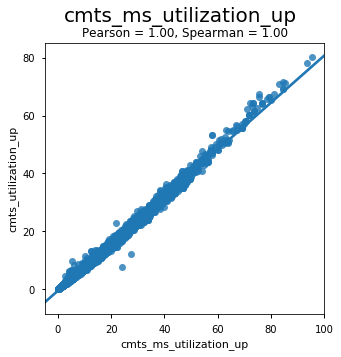

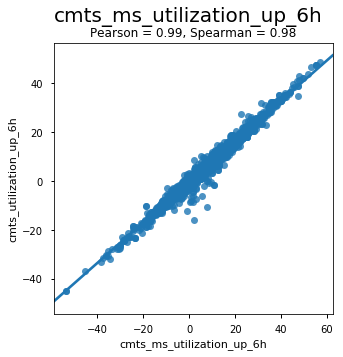

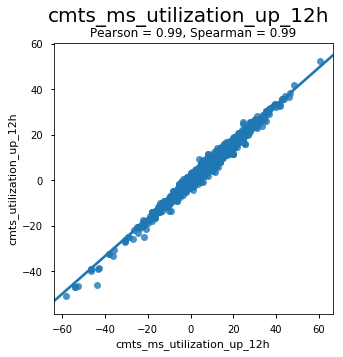

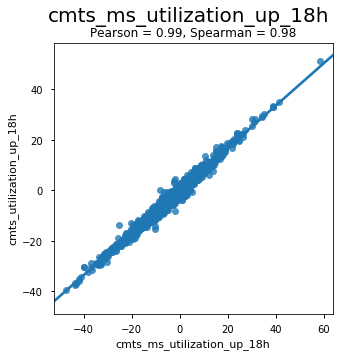

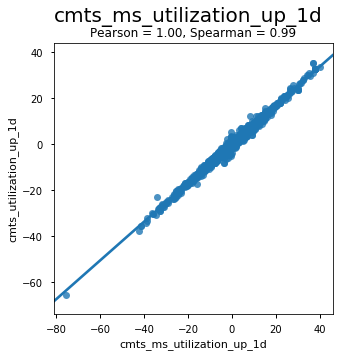

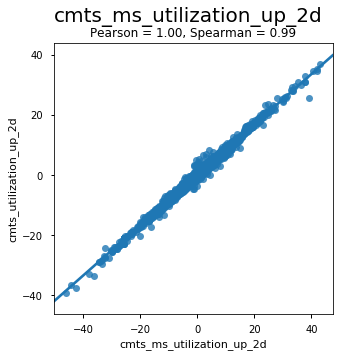

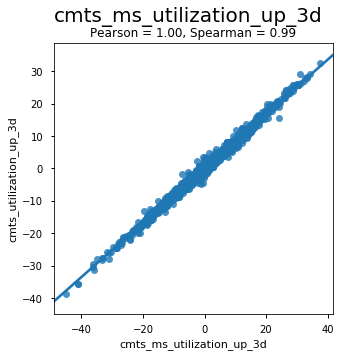

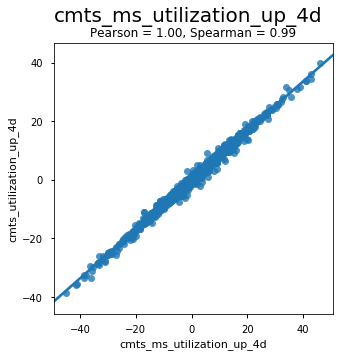

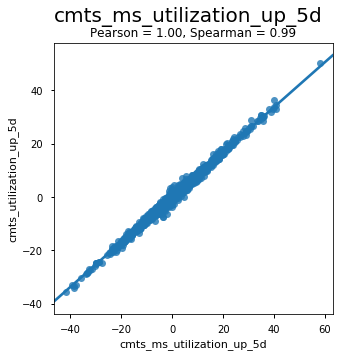

In [14]:
compare_candidate_identical('cmts_ms_utilization_up' ,['cmts_utilization_up'],suffixes_non_miss,x_no_missing)

The visual inspection confirms our hypothesis that ```cmts_ms_utilization_up``` <---> ```cmts_utilization_up```

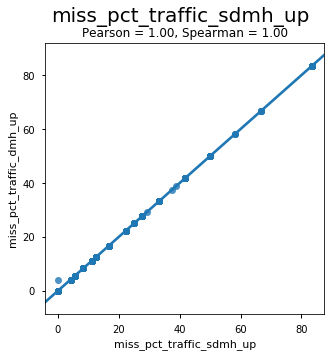

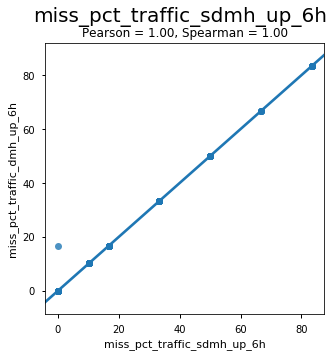

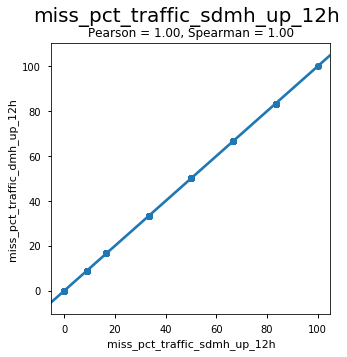

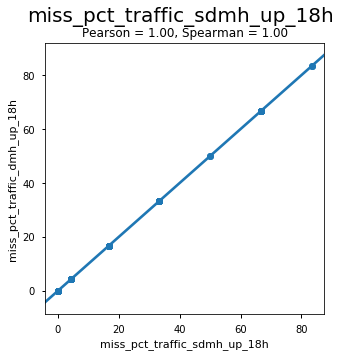

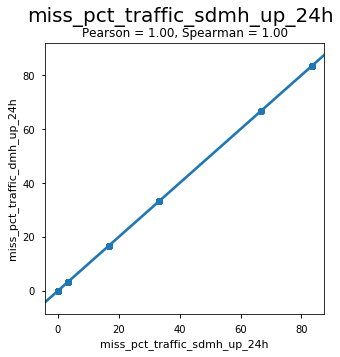

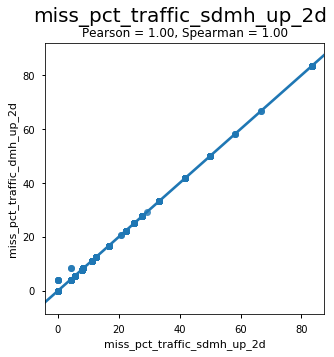

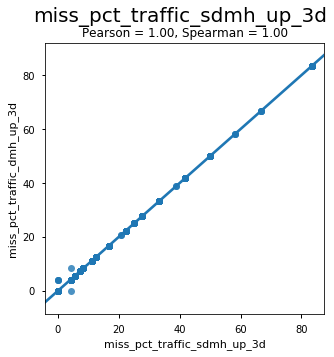

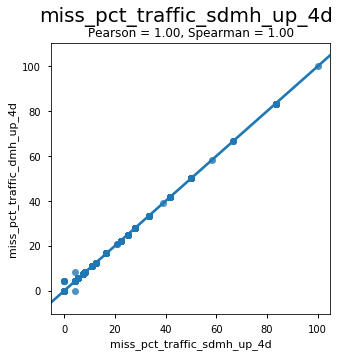

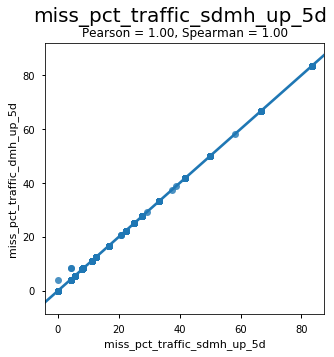

In [15]:
compare_candidate_identical('miss_pct_traffic_sdmh_up',['miss_pct_traffic_dmh_up'],suffixes_miss,x_no_missing)

Again a very simple inspection confirms the hypothesis that ```miss_pct_traffic_sdmh_up``` <---> ```miss_pct_traffic_dmh_up```

For the third group we will look at:
1. how similar ```miss_snr_dn``` is with each of ```miss_rx_dn``` and ```miss_tx_up```
2. then we will look at how ```miss_rx_dn``` and ```miss_tx_up``` relate

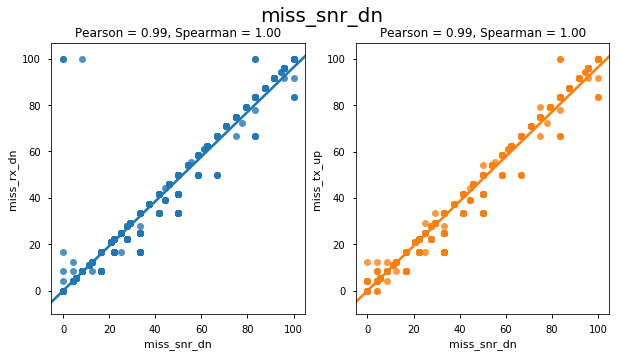

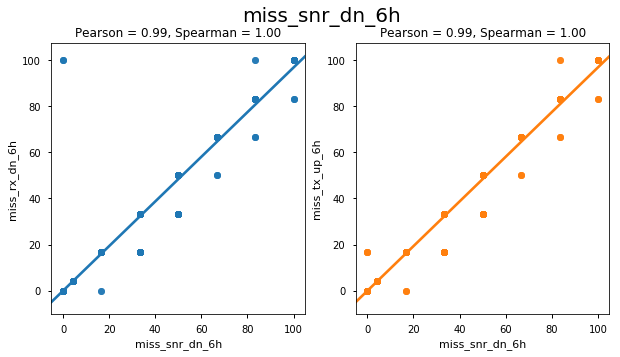

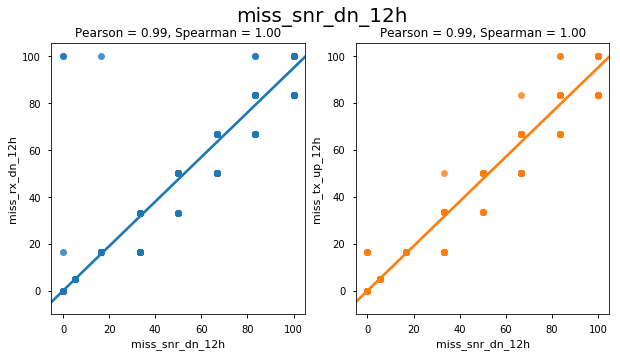

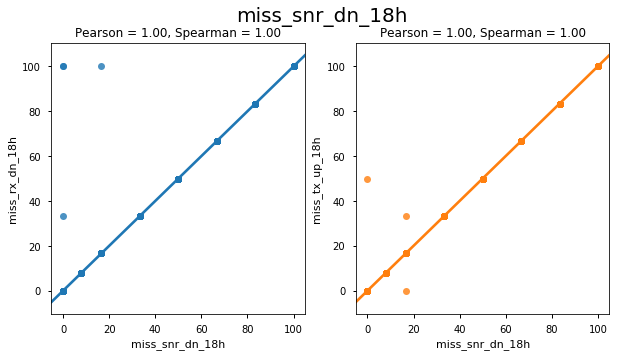

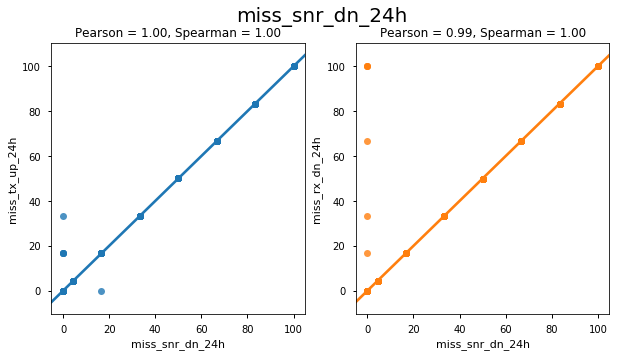

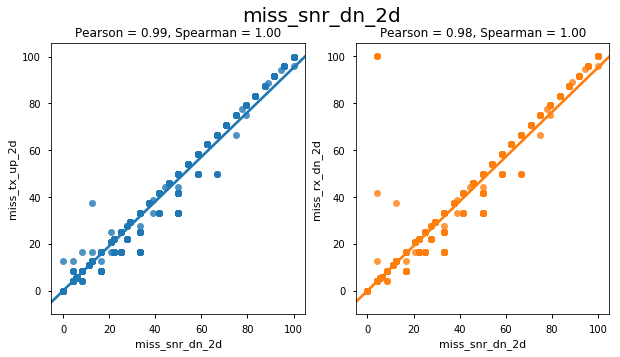

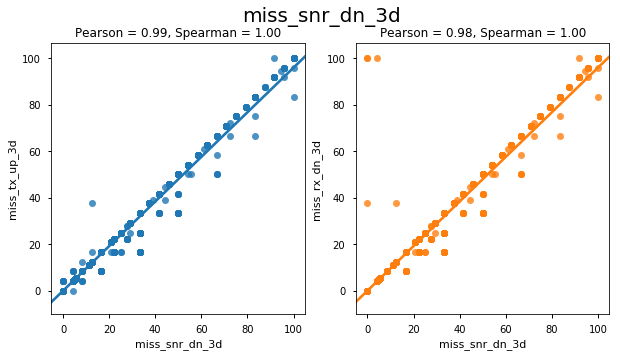

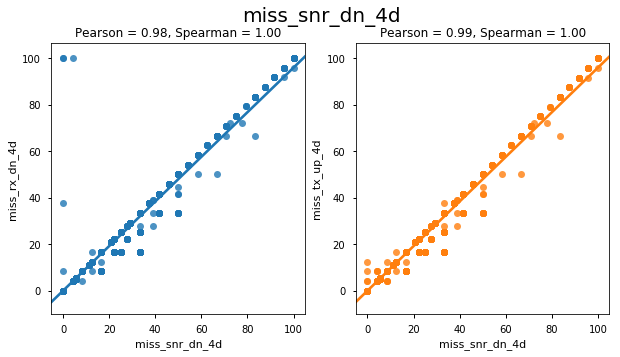

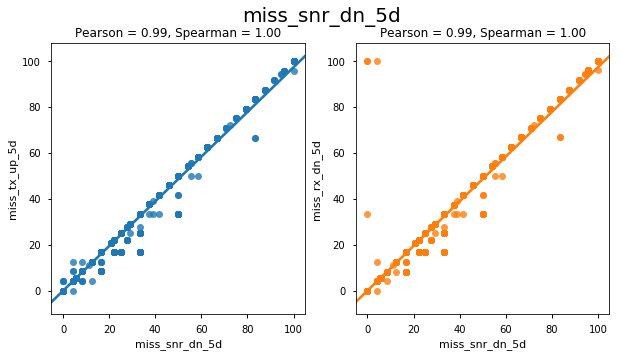

In [16]:
compare_candidate_identical('miss_snr_dn',['miss_rx_dn','miss_tx_up'],suffixes_miss,x_no_missing)

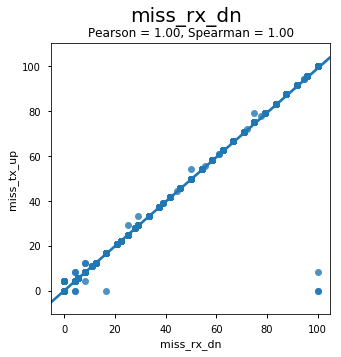

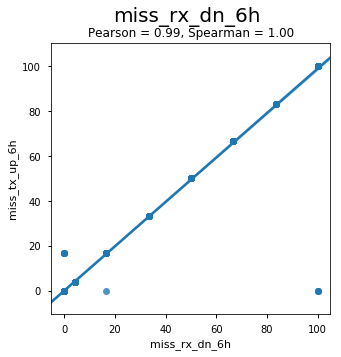

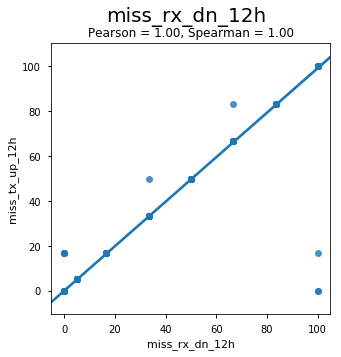

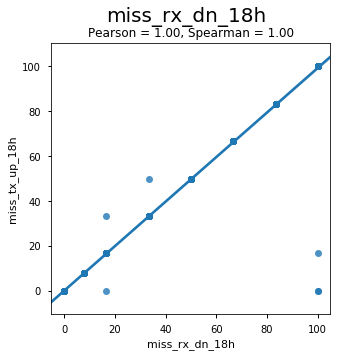

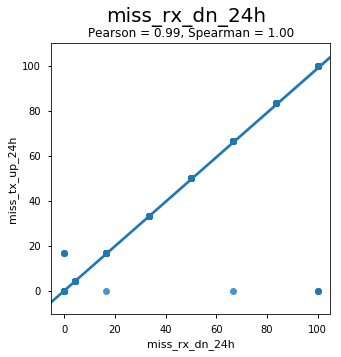

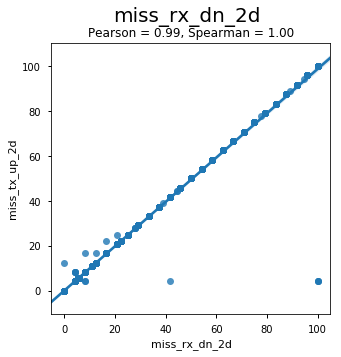

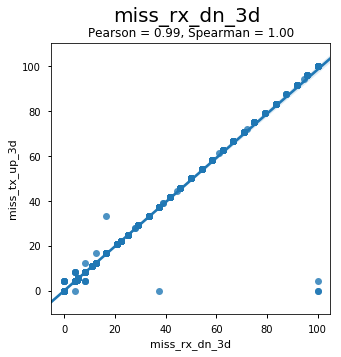

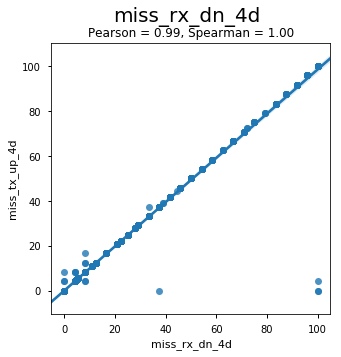

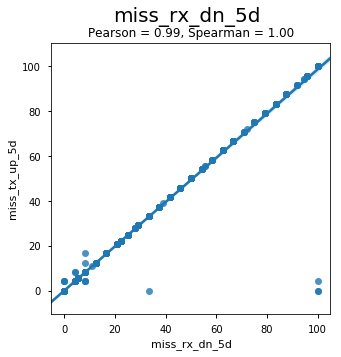

In [17]:
compare_candidate_identical('miss_rx_dn',['miss_tx_up'],suffixes_miss,x_no_missing)

Pearson correlation always being higher than $0.98$ we are sure that the three variables are indeed a clique in terms of correlation.

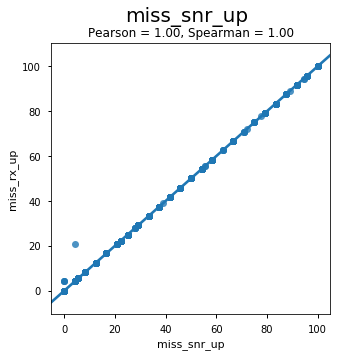

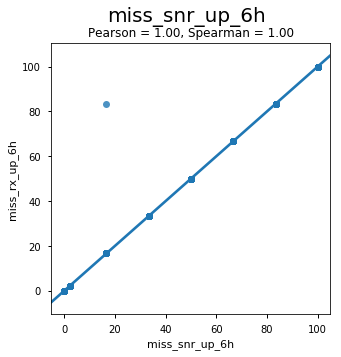

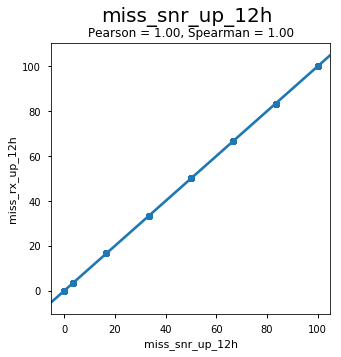

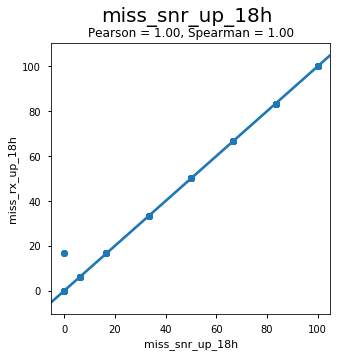

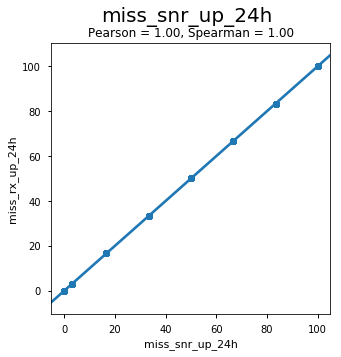

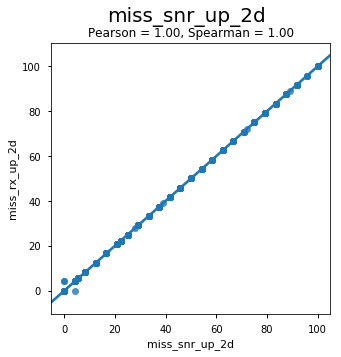

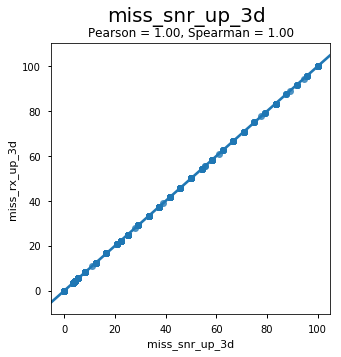

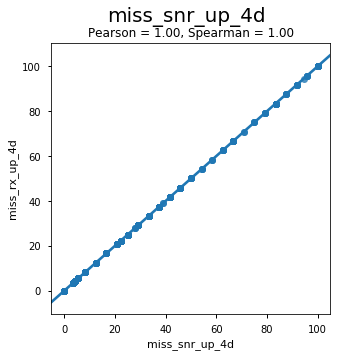

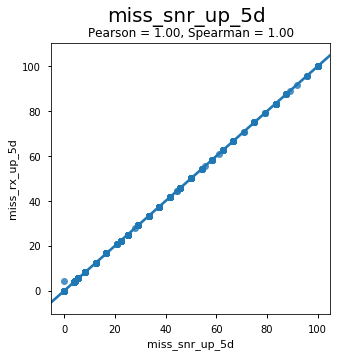

In [18]:
compare_candidate_identical('miss_snr_up',['miss_rx_up'],suffixes_miss,x_no_missing)

**We have shown that we are indeed in the presence of cliques in each 4 cases (where a connection is set when the two variables are highly correlated) and therefore we need to keep each time only one element per clique**

This choice will again be very arbitrary and we do not justify it.

In [19]:
to_drop = ['cmts_ms_utilization_up' + s for s in suffixes_non_miss] + \
                        ['miss_pct_traffic_sdmh_up' + s for s in suffixes_miss] + \
                        ['miss_rx_dn' + s for s in suffixes_miss] + \
                        ['miss_tx_up' + s for s in suffixes_miss] + \
                        ['miss_snr_up' + s for s in suffixes_miss]
dropped_features = dropped_features + to_drop

In [20]:
x_no_missing = x_no_missing.drop(labels=to_drop,axis=1)

In [21]:
x_no_missing.shape

(11160, 234)

#### Remaining ones

Now that we have taking out all this cases that unveiled an underlying pattern we can look at particular cases. To do that we run the test again on the remaining dataframe.

In [22]:
correlated_lists,identical_lists = find_correlation(x_no_missing)
print('We have {} identical feature-pairs'.format(len(identical_lists)))
print('We have {} groups of correlated features'.format(len(correlated_lists)))

We have 0 identical feature-pairs
We have 3 groups of correlated features


In [23]:
correlated_lists

{'miss_cer_up': {'miss_cer_up_24h'},
 'miss_rx_up_6h': {'offline_pct_6h'},
 'miss_snr_dn': {'miss_rx_up'}}

Looking at the list of correlated variables we can see that one of the main problems is that this time we do not have each time dimension of the two features matching. Therefore it means that this correlation might hold only on this particular dataset but maybe not on future values.

we will look at these cases individually

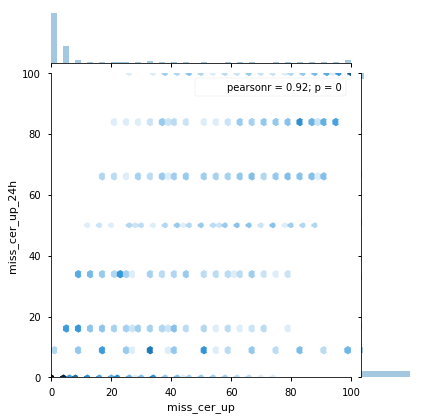

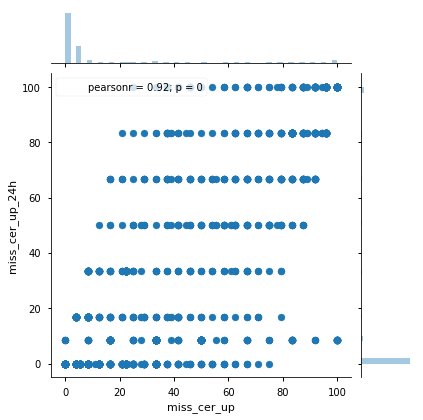

In [24]:
sns.jointplot("miss_cer_up", "miss_cer_up_24h", data=x_no_missing, kind="hex", joint_kws = {'bins':'log'})
sns.jointplot("miss_cer_up", "miss_cer_up_24h", data=x_no_missing)

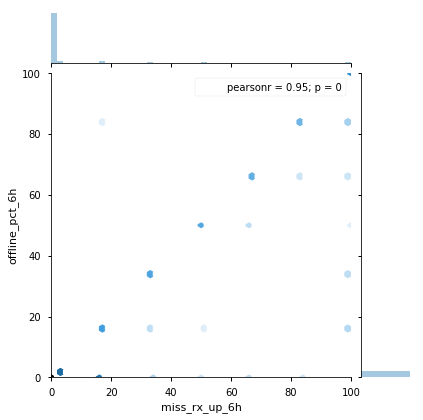

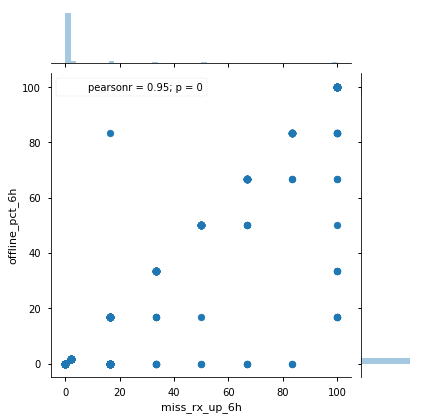

In [25]:
sns.jointplot("miss_rx_up_6h", "offline_pct_6h", data=x_no_missing, kind="hex", joint_kws = {'bins':'log'})
sns.jointplot("miss_rx_up_6h", "offline_pct_6h", data=x_no_missing)

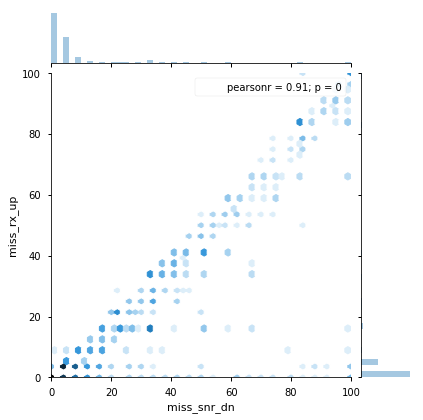

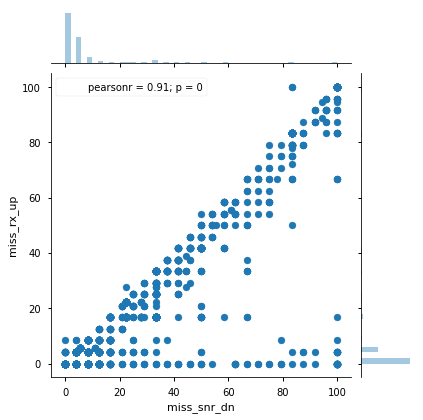

In [26]:
sns.jointplot("miss_snr_dn", "miss_rx_up", data=x_no_missing, kind="hex", joint_kws = {'bins':'log'})
sns.jointplot("miss_snr_dn", "miss_rx_up", data=x_no_missing)

Looking at the plots we can see that the high correlation of those pairs of features reside in the fact that most of the samples are located near the $(0,0)$ point and therefore we decide not to consider them as highly correlated (if they really were we should also see correlation for other time periods - like we saw in previously).

So we will keep a list of features that we wish to leave out of our analysis for later.

In [27]:
print('By analysing correlated features we have succeeded to get rid of {} features ({}% reduction).'.format(len(dropped_features),100*len(dropped_features)/x_encoded.shape[1]))

By analysing correlated features we have succeeded to get rid of 54 features (18.75% reduction).


_Remark: the fact that we have found identical features also explain why LDA was complaining about some colinear columns_

## Low variance columns
It is also interesting to look at columns which variance is low. Indeed we wish to investigate predictors that are have both of the following characteristics: 
* very few unique values relative to the number of samples 
* the ratio of the frequency of the most common value to the frequency of the second most common value

In [28]:
columns_to_investigate = nearZeroVar(x_no_missing)
columns_to_investigate

['offline_pct_6h',
 'offline_pct_12h',
 'offline_pct_18h',
 'offline_pct_24h',
 'offline_pct',
 'offline_pct_1d',
 'offline_pct_2d',
 'offline_pct_3d',
 'offline_pct_4d',
 'offline_pct_5d',
 'miss_cer_dn_6h',
 'miss_cer_dn_12h',
 'miss_cer_dn_24h',
 'pct_traffic_dmh_up_18h',
 'pct_traffic_dmh_up',
 'pct_traffic_sdmh_up_6h',
 'pct_traffic_sdmh_up_18h',
 'pct_traffic_sdmh_up',
 'pct_traffic_sdmh_up_1d',
 'pct_traffic_sdmh_up_2d',
 'pct_traffic_sdmh_up_3d',
 'pct_traffic_sdmh_up_4d',
 'pct_traffic_sdmh_up_5d',
 'miss_rx_up_6h',
 'miss_rx_up_12h',
 'miss_rx_up_24h',
 'model_1',
 'model_2',
 'model_3',
 'model_5',
 'model_6']

As a first observation we can say that all these columns are discrete (since they are mostly percentages out of 6 measurements). Then there is also the ```model_*``` features that are _One hot encoding_ and for which we therefore expect a low variance. 

We will focus on the features starting by ```pct_traffic_*``` as they are indeed percentages but we are not sure in what domain are they expressed.

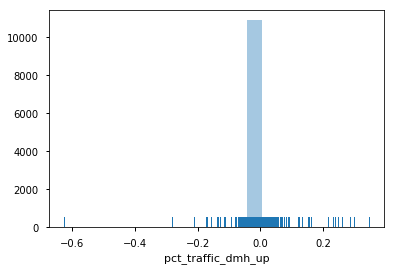

In [29]:
sns.distplot(x_no_missing['pct_traffic_dmh_up'], bins=20, kde=False, rug=True);

In [30]:
x_no_missing['pct_traffic_dmh_up'].value_counts()

 0.000000    10115
-0.001437        9
-0.002522        5
-0.009566        5
 0.008485        5
-0.033182        5
-0.000331        4
-0.021442        4
-0.000228        3
 0.000674        3
-0.057904        3
-0.007436        3
 0.001955        3
-0.003739        3
-0.000200        3
-0.008303        3
 0.000281        3
-0.045545        3
-0.000304        3
 0.000319        2
-0.000324        2
-0.001704        2
-0.007694        2
-0.000846        2
-0.002174        2
 0.016750        2
-0.000311        2
-0.000850        2
-0.001657        2
 0.000246        2
             ...  
 0.001345        1
 0.051027        1
 0.088409        1
 0.043853        1
 0.022859        1
 0.000472        1
-0.014080        1
 0.030556        1
-0.013184        1
 0.007212        1
 0.020751        1
-0.009785        1
 0.012412        1
 0.055180        1
-0.002350        1
-0.003631        1
 0.006340        1
-0.001961        1
-0.015856        1
 0.001475        1
 0.002307        1
-0.000930   

In [31]:
x_s,y_s = get_balanced_classes(x_no_missing.values,y)
sample_df = pd.DataFrame(x_s, columns = x_no_missing.columns)
sample_df['pct_traffic_dmh_up'].value_counts()

 0.000000    2108
-0.033182       5
-0.001437       5
-0.002522       5
-0.009566       5
 0.008485       4
 0.000674       3
-0.008303       3
-0.007436       3
 0.019178       2
-0.008094       2
-0.027357       2
-0.000575       2
-0.037189       2
-0.000204       2
-0.002350       2
-0.001691       2
-0.000245       2
-0.007941       2
 0.040230       2
-0.000304       2
 0.000602       2
-0.002646       1
 0.010061       1
 0.016506       1
-0.000155       1
 0.000148       1
-0.117009       1
 0.005682       1
-0.024441       1
             ... 
 0.022696       1
-0.005456       1
-0.004025       1
 0.011957       1
 0.029956       1
-0.000267       1
-0.001779       1
-0.000324       1
-0.004216       1
 0.016158       1
 0.029787       1
 0.004282       1
-0.003952       1
-0.033130       1
 0.025000       1
-0.001812       1
 0.000577       1
-0.000160       1
-0.008494       1
-0.000930       1
-0.013861       1
 0.002676       1
-0.038710       1
 0.025706       1
 0.009511 

Once we are looking into the distribution of the variable we are quite sceptic regarding how deleting this feature would make sense so we decide to leave it for a later feature selection round (once we have a classifier we csan use it to discard the features that are not very meaningful by ranking them).

# Scaling the features

## Witness 

In [32]:
from sklearn import *
LDA = sklearn.discriminant_analysis.LinearDiscriminantAnalysis()
x_ready = LDA.fit_transform(x_s,y_s)
K_means = sklearn.cluster.MiniBatchKMeans(n_clusters=2,batch_size=600)
labels = K_means.fit_predict(x_ready)

In [33]:
analyse_clustering(y_s,labels)

Precision = 62.507%	Recall = 91.237%


Desc  Counts  Label proportion  Cluster proportion
Cluster Labels                                                               
healthy 0.0      True positives    1062         91.237113           62.507357
        1.0     False positives     637         54.725086           37.492643
sick    0.0     False negatives     102          8.762887           16.216216
        1.0      True negatives     527         45.274914           83.783784

## Standardizing

In [34]:
x_scaled = pd.DataFrame(preprocessing.scale(x_no_missing), columns = x_no_missing.columns)
x_s,y_s = get_balanced_classes(x_no_missing.values,y)
x_ready = LDA.fit_transform(x_s,y_s)
K_means = sklearn.cluster.MiniBatchKMeans(n_clusters=2,batch_size=600)
labels = K_means.fit_predict(x_ready)
analyse_clustering(y_s,labels)

Precision = 64.551%	Recall = 86.512%


Desc  Counts  Label proportion  Cluster proportion
Cluster Labels                                                               
healthy 0.0      True positives    1007         86.512027           64.551282
        1.0     False positives     553         47.508591           35.448718
sick    0.0     False negatives     157         13.487973           20.442708
        1.0      True negatives     611         52.491409           79.557292

## Robust Scaling 

In [35]:
x_scaled = pd.DataFrame(sklearn.preprocessing.robust_scale(x_no_missing,quantile_range=(1.0,99.0)), columns = x_no_missing.columns)
x_s,y_s = get_balanced_classes(x_no_missing.values,y)
x_ready = LDA.fit_transform(x_s,y_s)
K_means = sklearn.cluster.MiniBatchKMeans(n_clusters=2,batch_size=600)
labels = K_means.fit_predict(x_ready)
analyse_clustering(y_s,labels)

Precision = 61.48%	Recall = 90.636%


Desc  Counts  Label proportion  Cluster proportion
Cluster Labels                                                               
healthy 0.0      True positives    1055         90.635739           61.480186
        1.0     False positives     661         56.786942           38.519814
sick    0.0     False negatives     109          9.364261           17.810458
        1.0      True negatives     503         43.213058           82.189542